In [ ]:
# %pip install lambeq
# %pip install pytket-qiskit
# %pip install pennylane

In [ ]:
import os
import re
import warnings
import csv
import numpy as np
import ast
import pandas as pd

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [ ]:
BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

Preparing data

In [ ]:
with open("data/spam_email_dataset.csv", "r", encoding="utf-8") as source:
    reader = csv.reader(source)

    with open("data/spam_email.csv", "w", encoding="utf-8") as result:
        writer = csv.writer(result)
        for r in reader:
            writer.writerow((r[1], r[2], r[15]))

In [ ]:
df = pd.read_csv("data/spam_email.csv")
df['Sender'] = df['Subject']
df['Subject'] = df['Spam Indicator']
df.drop('Spam Indicator', inplace=True, axis=1)
df.to_csv('data/fixed_output.csv')

In [ ]:
with open("data/fixed_output.csv", "r", encoding="utf-8") as source:
    reader = csv.reader(source)

    with open("data/data_output.txt", "w", encoding="utf-8") as result:
        for r in reader:
            result.write(f"{r[1]} {r[2]}\n")

Split data to train and test

In [ ]:
with open("data/data_output.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[1:200]

with open("data/data_output_train.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

In [ ]:
with open("data/data_output.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[201:250]

with open("data/data_output_test.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

Split data to train and test

In [ ]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('data/data_output_train.txt')
val_labels, val_data = read_data('data/data_output_test.txt')

In [ ]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    EPOCHS = 1

In [ ]:
train_data[:5]

['Even hotel community church.',
 'Try themselves guess fight white agreement thus although.',
 'Environmental commercial off seem any conference.',
 'Smile real TV father commercial day increase.',
 'Fast stage he oil institution.']

In [ ]:
train_labels[:5]

[[1, 0], [1, 0], [1, 0], [0, 1], [1, 0]]

In [ ]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'),verbose='progress')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences:   0%|          | 0/49 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/196 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/196 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/12 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/48 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

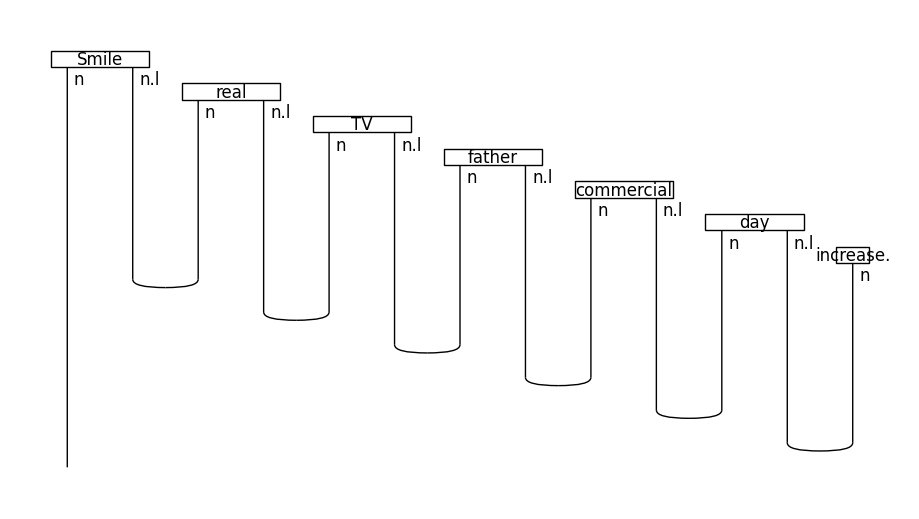

In [ ]:
train_diagrams[3].draw(figsize=(9, 5), fontsize=12)

In [ ]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

atomic_types = {
    AtomicType.NOUN: 1,
    AtomicType.SENTENCE: 0
}

ansatz = IQPAnsatz(atomic_types, n_layers=1, n_single_qubit_params=3)

train_circuits = []
val_circuits = []

for i, diagram in enumerate(train_diagrams):
    try:
        train_circuits.append(ansatz(remove_cups(diagram)))
    except KeyError as e:
        print(f"Ignoring the error in train_diagram {i + 1}: {e}")
        print(f"Problematic diagram text: {diagram}")

for i, diagram in enumerate(val_diagrams):
    try:
        val_circuits.append(ansatz(remove_cups(diagram)))
    except KeyError as e:
        print(f"Ignoring the error in val_diagram {i + 1}: {e}")
        print(f"Problematic diagram text: {diagram}")


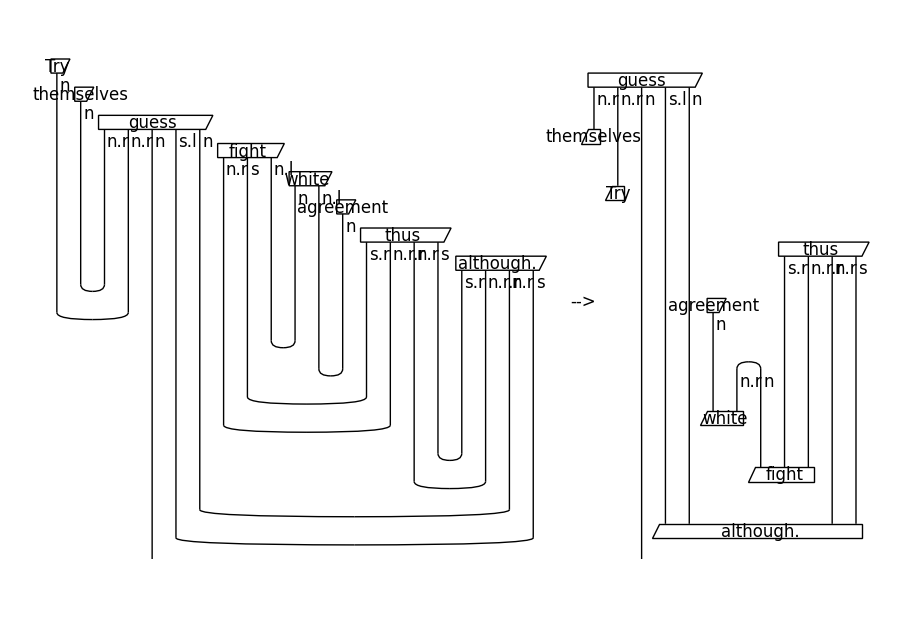

In [ ]:
from discopy.drawing import Equation

original_diagram = train_diagrams[1]
removed_cups_diagram = remove_cups(original_diagram)

Equation(original_diagram, removed_cups_diagram, symbol='-->').draw(figsize=(9, 6), asymmetry=0.3, fontsize=12)

In [ ]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [ ]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [ ]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

In [ ]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [ ]:
trainer.fit(train_dataset, val_dataset, early_stopping_interval=10)

Epoch 1:    train/loss: 4.9356   valid/loss: 2.2978   train/acc: 0.4848   valid/acc: 0.5000
Epoch 2:    train/loss: 2.6158   valid/loss: 2.3702   train/acc: 0.5000   valid/acc: 0.4737
Epoch 3:    train/loss: 4.4636   valid/loss: 1.7553   train/acc: 0.5758   valid/acc: 0.4868
Epoch 4:    train/loss: 0.7897   valid/loss: 2.3061   train/acc: 0.5364   valid/acc: 0.4605
Epoch 5:    train/loss: 2.6825   valid/loss: 2.7770   train/acc: 0.5394   valid/acc: 0.4737
Epoch 6:    train/loss: 6.5593   valid/loss: 2.2965   train/acc: 0.5242   valid/acc: 0.5132
Epoch 7:    train/loss: 1.1271   valid/loss: 1.7879   train/acc: 0.5273   valid/acc: 0.4474
Epoch 8:    train/loss: 0.6604   valid/loss: 2.8719   train/acc: 0.4818   valid/acc: 0.4737
Epoch 9:    train/loss: 5.3481   valid/loss: 1.8598   train/acc: 0.5364   valid/acc: 0.4474
Epoch 10:   train/loss: 2.5907   valid/loss: 1.8483   train/acc: 0.5121   valid/acc: 0.4605
Epoch 11:   train/loss: 2.5030   valid/loss: 2.3560   train/acc: 0.5273   valid/

Validation accuracy: 0.4473684210526316


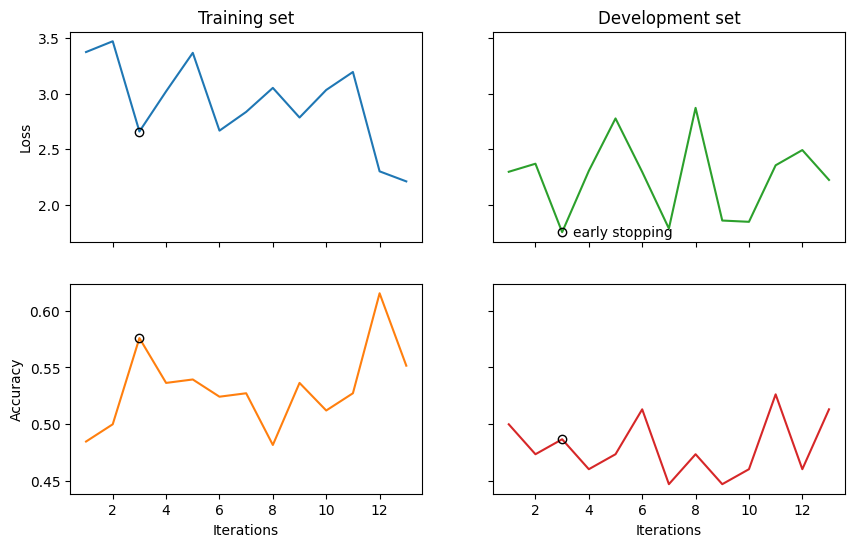

In [27]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmin(trainer.val_costs)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())